In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
## Data set:
## http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [3]:
columns = ['duration','protocol_type','service','flag','src_bytes',
          'dst_bytes','land','wrong_fragment','urgent','hot',
           'num_falied_logins','logged_in','num_compromised',
          'root_shell','su_attempted','num_root','num_file_creations',
          'num_shells','num_access_files','num_outbound_cmds',
          'is_host_login','is_guest_login','count','srv_count',
           'serror_rate','srv_serror_rate','rerror_rate',
          'srcv_rerror_rate','same_srv_rate','diff_srv_rate',
          'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
          'dst_host_same_srv_rate','dst_host_diff_srv_rate',
          'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
          'dst_host_serror_rate','dst_host_srv_serror_rate',
          'dst_host_rerror_rate','dst_host_srv_rerror_rate',
          'label']
df = pd.read_csv('kddcup.data.corrected',sep =',',names=columns,
                index_col=None)

In [4]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
df.label.value_counts()

smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: label, dtype: int64

In [ ]:
## We filter out normal data entries.
## We will make two data frames: one with only normal entries and one with a mix of normal + anomalies

In [8]:
df = df[df['service'] == 'http'] ## We focus on http services
df = df.drop('service',axis=1)
columns.remove('service')

In [9]:
novelties = df[df['label'] != 'normal.'] ## 4045 entries of anomalies
novelties_normal = df[150000:154045] ## 4045 entries of normal

In [10]:
novelties = pd.concat([novelties,novelties_normal]) # half anomalies, half normal
normal = df[df['label'] == 'normal.']

In [ ]:
# we use label encoder for categorical columns in both dataframes

In [21]:
for col in normal.columns:
    if normal[col].dtype == 'object':
        encoder1 = LabelEncoder()
        encoder1.fit(normal[col])
        normal[col] = encoder1.transform(normal[col])
        
for col in novelties.columns:
    if novelties[col].dtype == 'object':
        encoder2 = LabelEncoder()
        encoder2.fit(novelties[col])
        novelties[col] = encoder2.transform(novelties[col])
        
      

/Users/aldodector/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [ ]:
# Building validation tests. They are built on normal entries.

In [28]:
for f in range(0,10): ## We shuffle indexes
    normal = normal.iloc[np.random.permutation(len(normal))]
    
df2 = pd.concat([normal[:100000],normal[200000:250000]])  # all normal entries
df_validate = normal[100000:150000] # same

In [30]:
X_train, X_test = train_test_split(df2, test_size=0.2, random_state=42)
X_val = df_validate

In [ ]:
## We fit our OC-SVM model

In [33]:
oc_svm = OneClassSVM(kernel = 'rbf',gamma = 0.0004,random_state = 42, nu = 0.1)

In [34]:
oc_svm.fit(X_train)

/Users/aldodector/anaconda3/lib/python3.6/site-packages/sklearn/svm/classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0004, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=42, shrinking=True, tol=0.001,
            verbose=False)

In [ ]:
## Lets try model on test data

In [35]:
preds = oc_svm.predict(X_test)

In [47]:
score = 0
for i in range(0,len(X_test)):
    if (preds[i] == 1) :
        score += 1

accuracy = score / len(X_test) ## Accuracy is the percentage of data points that are normal data points.
print('Acc:', accuracy)

Acc: 0.8396


In [38]:
## so, accuracy is good, given that we supposed that 10% of data would misclassify (meaning max acc = 90%)

True

In [ ]:
## We run model on validation set:

In [49]:
preds = oc_svm.predict(X_val)
score = 0
for i in range(0,len(X_val)):
    if (preds[i] == 1) :
        score += 1

accuracy = score / len(X_val) ## Accuracy is the percentage of data points that are normal data points.
print('Acc:', accuracy)

Acc: 0.8395


In [ ]:
## We now test on novelties data set. 
## This time, we can test AUC because we have positives + negatives. 
## The model an classify false positive and true negatives

In [50]:
from sklearn.metrics import roc_auc_score

In [51]:
preds = oc_svm.predict(novelties)
matches = (novelties['label'] == 4)
auc = roc_auc_score(preds,matches)
print('AUC: ',auc)

AUC:  0.936047848190862


In [ ]:
## Good AUC score. 

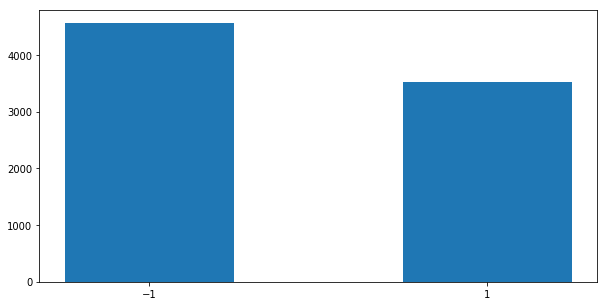

In [53]:
plt.figure(figsize=(10,5))
plt.hist(preds, bins = [-1.5,-0.5] + [0.5,1.5],align='mid')
plt.xticks([-1,1])
plt.show()

In [ ]:
## The model predicts more anomalies than normal data points. 
## But, from AUC, it manages to classify most normal datapoint correctly. 